### 問題設定
$x0 \in [0, 10]$の点を$T = f(x0)$で表されるTに$a \in \{*2, +1, end, -1, /2\}$から作用する演算を複数回用いて、なるべく速くたどり着くする。

これを多段意思決定問題として考えると、  
状態表現を$s \in \mathbb{R}^m$ 行動ベクトルを$a \in \mathbb{R}^n, a_i = \mathbb{I}(i = index \,of \,action)$とおくと、  
より速く目標値にたどり着くほど値が大きくなるような、報酬関数から得られる即時報酬の総和の期待値である
$$E[\sum_{t=0}^{T} \gamma^t R_t]$$
を最大化するような、  
ある状態に取る行動の条件付き確率である方策$\pi(a|s)$から、最良な方策$^*\pi(a|s)$を選ぶ問題として考えられる。

In [1]:
import torch as tc
from tqdm.notebook import tqdm
from torch.nn import functional as F
# 環境、結果の可視化、Tにたどり着くかの確認は別で切り分けた
# Agent, trainの部分のみnotebookで記述
from env_and_tools import ACTION_DIM, SPAN_LENGTH, Env, View, Test
from torch import nn
from torch.nn import functional as F
from torch import optim
from torch.autograd import detect_anomaly

device = tc.device('cuda:0')

from collections import defaultdict, namedtuple, deque
import random

Experience = namedtuple('Experience', ('s', 'a', 'ns', 'r', 'd'))

In [2]:
class NNQualityFunction(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.affine1 = nn.Linear(state_dim, 100)
        self.affine2 = nn.Linear(100, 60)
        self.affine3 = nn.Linear(60, action_dim)
        nn.init.kaiming_normal_(self.affine1.weight)
        nn.init.kaiming_normal_(self.affine2.weight)
        nn.init.kaiming_normal_(self.affine3.weight)
        
    def forward(self, x):
        x = F.relu(self.affine1(x))
        x = F.relu(self.affine2(x))
        return self.affine3(x)  

In [3]:
class Agent(object):
    def __init__(self, state_dim, action_dim=ACTION_DIM, eps=0.1, lr=0.1, gamma=0.9):
        self.eps = eps
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.gamma = gamma
        self.Q_function = NNQualityFunction(state_dim, action_dim)
        self.Q_function.to(device)
        # Fixed Target Network
        self.teacher_model = NNQualityFunction(state_dim, action_dim)
        self.teacher_model.to(device)
#         self.criterion = F.smooth_l1_loss
        self.criterion = nn.MSELoss()
        self.optimizer = optim.RMSprop(self.Q_function.parameters(), lr=lr)
#         self.optimizer = optim.SGD(self.Q_function.parameters(), lr=lr)
    
    def policy(self, s, play=False):
        if not play and tc.rand(()) < self.eps:
            return tc.randint(ACTION_DIM, ())
        with tc.no_grad():
            action_qualities = self.Q_function(s.v)
        return tc.argmax(action_qualities)
    
    def update(self, batch):
        estimation_qualities = []
        true_qualities = []
        for i, e in enumerate(batch):
            est = self.Q_function(e.s.v)
            v = e.r
            if not e.d:
                with tc.no_grad():
                    v += self.gamma * tc.max(self.Q_function(e.ns.v))
            estimation_qualities.append(est[e.a])
            true_qualities.append(v)
        estimation_qualities = tc.stack(estimation_qualities)
        true_qualities = tc.tensor(true_qualities).to(device)
        self.optimizer.zero_grad()
        try:
            loss = self.criterion(estimation_qualities, true_qualities)
            loss.backward()
        except Exception:
            print(estimation_qualities)
            print(true_qualities)
            raise
        self.optimizer.step()

In [4]:
# 学習
starts=[0, 3, 5, 8, 10]
# starts = list(range(11))

def train(agent, seed=0, train_episode_num=10000):
    rewards_record_per_init = {key: [] for key in range(SPAN_LENGTH)}
    rewards_record_per_init['all'] = []
    training_count = 0
    
    # Experience Replay
    experiences = deque(maxlen=1024)

    for _ in tqdm(range(train_episode_num)):
        Ri = 0
        init = random.choice(starts)
        env = Env(init)
        s = env.state
        for _ in range(1000):
            # 行動を選択
            a = agent.policy(s)
            ns, r, d = env.step(a)
            e = Experience(s, a, ns, r, d)
            experiences.append(e)
            s = ns
            Ri = Ri + r
            if d:
                break
        if len(experiences) == 1024:
            batch = random.sample(experiences, 64)
            agent.update(batch)
            training_count += 1
            
        # 3回に一回teacher_modelを更新する
#         if training_count % 3 == 0:
#             batch = 

            

        rewards_record_per_init[int(init)].append(Ri)
        rewards_record_per_init['all'].append(Ri)
    return {key: tc.tensor(r).to(device) for key, r in rewards_record_per_init.items()}

In [8]:
seed = 0
random.seed(seed)
tc.random.manual_seed(seed)
agent = Agent(state_dim=12, eps=0.3, lr=0.01)
R = train(agent, train_episode_num=10000)

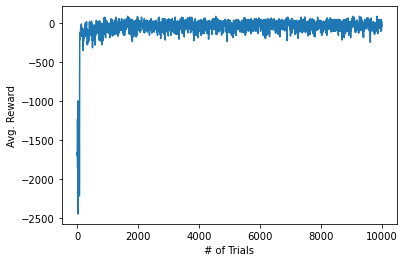

<Figure size 432x288 with 0 Axes>

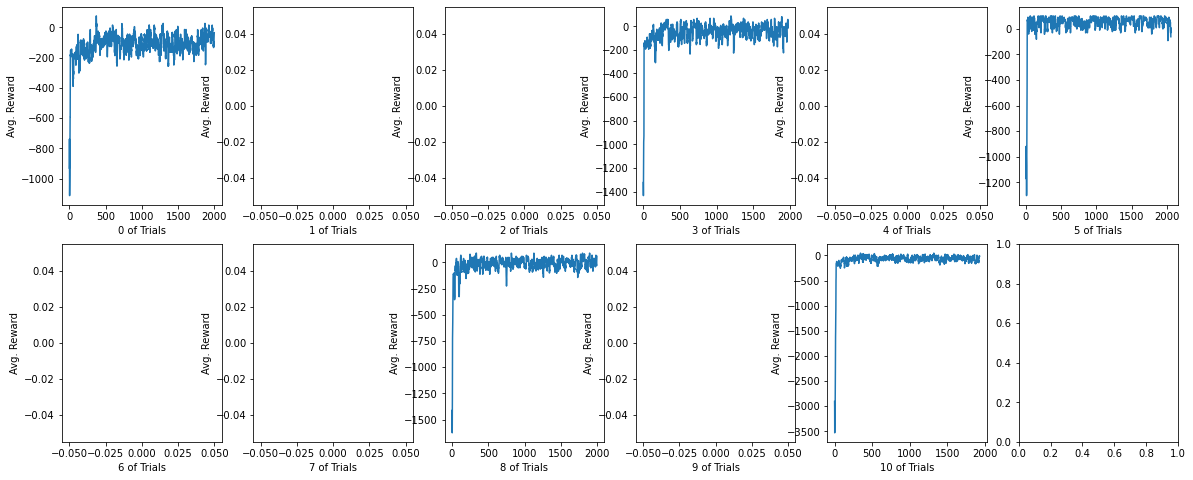

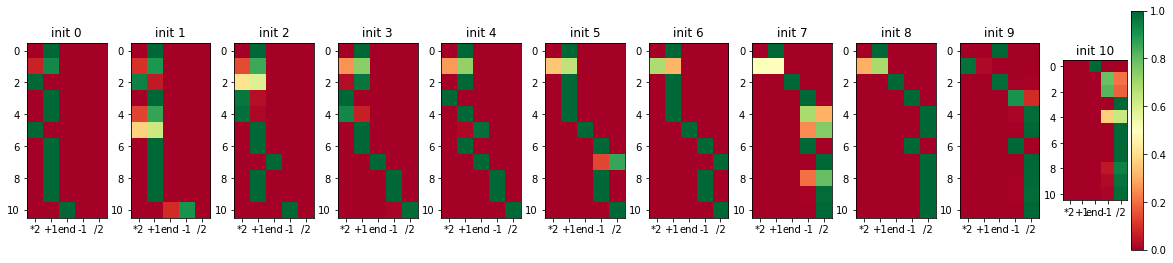

init = 0, T = 10, solved!

init = 1, T = 9, -

init = 2, T = 8, -

init = 3, T = 7, solved!

init = 4, T = 6, -

init = 5, T = 5, solved!

init = 6, T = 4, -

init = 7, T = 3, -

init = 8, T = 2, solved!

init = 9, T = 1, -

init = 10, T = 0, solved!



In [9]:
View.view(agent, R.copy(), n=10)
Test.test_all_init(agent)

In [10]:
for i in range(11):
    Test.test_specific_init(agent, i, max_episode_length=20)
    print()

start from 0
T = tensor(10, device='cuda:0')
visited states [0, 1, 2, 4, 5, 10, 10]
took actions ['+1', '+1', '*2', '+1', '*2', 'end']
got rewards [-1.0, -1.0, -1.0, -1.0, -1.0, 100.0]
total reward =  95.0

start from 1
T = tensor(9, device='cuda:0')
visited states [1, 2, 4, 5, 6, 7, 8, 9, 10, 9, 10, 9, 10, 9, 10, 9, 10, 9, 10, 9, 10]
took actions ['+1', '*2', '+1', '+1', '+1', '+1', '+1', '+1', '-1', '+1', '-1', '+1', '-1', '+1', '-1', '+1', '-1', '+1', '-1', '+1']
got rewards [-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -101.0, -1.0, -101.0, -1.0, -101.0, -1.0, -101.0, -1.0, -101.0, -1.0, -101.0, -1.0, -101.0]
total reward =  -720.0

start from 2
T = tensor(8, device='cuda:0')
visited states [2, 3, 6, 7, 7]
took actions ['+1', '*2', '+1', 'end']
got rewards [-1.0, -1.0, -1.0, -100.0]
total reward =  -103.0

start from 3
T = tensor(7, device='cuda:0')
visited states [3, 6, 7, 7]
took actions ['*2', '+1', 'end']
got rewards [-1.0, -1.0, 100.0]
total reward =  98.0

start from 4
T = tenso